# Testing: Training & Testing Various Models

### Setup data

In [1]:
import os
os.chdir("/home/ra-ugrad/Documents/Haleigh/MedicalImage")

from torch.utils.data import DataLoader
from src.dataloader_local import CancerDataset # TODO: check why it's not working from local
import src.dataloader_local as dl_local
import torch

In [2]:
mri_data = dl_local.get_mri_data()
mri_data = dl_local.clean_mri_data(mri_data)

train_data, test_data = dl_local.train_test(mri_data)
batch_size = 2

train_dataset = CancerDataset(labels=train_data, path="/home/ra-ugrad/Documents/Segmentations/")
test_dataset = CancerDataset(labels=test_data, path="/home/ra-ugrad/Documents/Segmentations/")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
from datetime import datetime
t = datetime.now().strftime("%m-%d-%Y")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### MEDSAM Testing

In [ ]:
import os
os.chdir("/home/ra-ugrad/Documents/Haleigh/MedicalImage")

# MedSAM Base Testing
import torch
import torch.nn as nn
from segment_anything import sam_model_registry
from torch.nn import Linear
from torch.nn import Embedding
from segment_anything.modeling.mask_decoder import MLP

from src.medsam_helper import medsam_test_results

In [2]:
MedSAM_CKPT_PATH = "./models/medsam_vit_b.pth"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)

In [4]:
MedSAM_CKPT_PATH = "/home/ra-ugrad/Documents/Haleigh/MedicalImage/models/medsam_vit_b.pth"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)

medsam_model.mask_decoder.num_mask_tokens = 8
medsam_model.mask_decoder.num_multimask_outputs = 7

medsam_model.image_encoder.patch_embed.proj = nn.Conv2d(3, 768, kernel_size = (35, 35), stride = (3, 3))
medsam_model.mask_decoder.mask_tokens = Embedding(medsam_model.mask_decoder.num_mask_tokens, 256)
medsam_model.mask_decoder.output_hypernetworks_mlps = nn.ModuleList([MLP(256, 256, 32, 3) for i in range(medsam_model.mask_decoder.num_mask_tokens)])
medsam_model.mask_decoder.iou_prediction_head.layers[2] = Linear(in_features=256, out_features=medsam_model.mask_decoder.num_mask_tokens, bias=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
import gc
import torch

# Delete specific variables if needed
# del logits, tune_model

# Garbage collect unused Python objects
gc.collect()

# Clear PyTorch CUDA memory cache
torch.cuda.empty_cache()

# Optional: force collection of inter-process memory
torch.cuda.ipc_collect()

In [10]:
!nvidia-smi

Fri May 30 21:16:44 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:41:00.0  On |                  Off |
|  0%   35C    P2              67W / 480W |  21710MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
# adjust model for training
from src.medsam_helper import MedSAM
tune_model = medsam_model = MedSAM(
    image_encoder=medsam_model.image_encoder,
    mask_decoder=medsam_model.mask_decoder,
    prompt_encoder=medsam_model.prompt_encoder,
).to(device)

In [6]:
# add model training here
from tqdm import tqdm
import monai
import numpy as np
import torch.nn.functional as F

img_mask_encdec_params = list(medsam_model.image_encoder.parameters()) + list(
    tune_model.mask_decoder.parameters()
)
optimizer = torch.optim.AdamW(
    img_mask_encdec_params, lr=1e-3, weight_decay=.01
)

seg_loss = monai.losses.DiceLoss(softmax=True, squared_pred=True, reduction="mean")
ce_loss = nn.CrossEntropyLoss()

num_epochs = 1
iter_num = 0
losses = []

In [7]:
for epoch in range(num_epochs):
    epoch_loss = 0
    for step, (img, seg, patient, b_level) in enumerate(tqdm(test_loader)):
        optimizer.zero_grad()
        B, H, W = img.size()

        img_3c = img.repeat(3, 1, 1, 1).view(B, 3, H, W).to(device)
        boxes_np = torch.Tensor(np.array([[0, 0, W, H]])).detach().cpu().numpy()
        img, seg = img.to(device), seg.to(device)

        logits = tune_model(img_3c, boxes_np)

        target_1hot = F.one_hot(seg, num_classes=logits.shape[1])
        target_1hot = target_1hot.permute(0, 3, 1, 2).float()

        loss = seg_loss(logits, target_1hot) + ce_loss(logits, seg)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 480/480 [02:45<00:00,  2.91it/s]


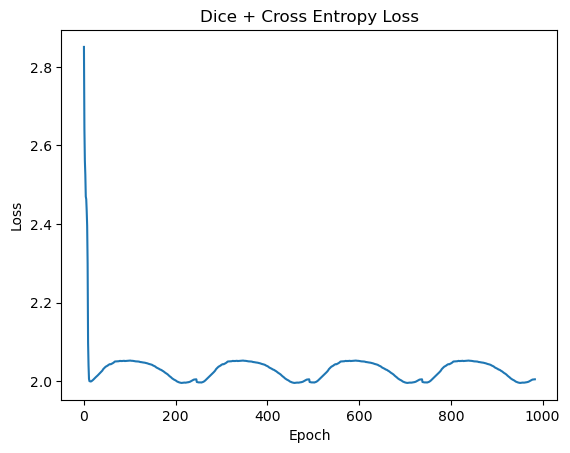

In [8]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title("Dice + Cross Entropy Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [17]:
grouped

Accuracy
Patient  Brightness                      
Duke_062 NEW Brightness level 1  0.935145
         NEW Brightness level 2  0.935171
         NEW Brightness level 3  0.935125
         NEW Brightness level 4  0.935121

In [8]:
tune_model.eval()
all_base_results = medsam_test_results(test_loader, tune_model, device)
grouped_base_results = all_base_results.groupby(["Patient", "Brightness"]).mean()

/home/ra-ugrad/Documents/Haleigh/MedicalImage/src/medsam_helper.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  acc = (torch.tensor(pred).clone().detach() == y).float().mean(dim=(1, 2)) #TODO: would be helpful to see acc by mask
/home/ra-ugrad/Documents/Haleigh/MedicalImage/src/medsam_helper.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({"Patient": patient, "Brightness": b_level, "Accuracy": acc})])


/home/ra-ugrad/Documents/Haleigh/MedicalImage/src/medsam_helper.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  acc = (torch.tensor(pred).clone().detach() == y).float().mean(dim=(1, 2)) #TODO: would be helpful to see acc by mask
/home/ra-ugrad/Documents/Haleigh/MedicalImage/src/medsam_helper.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  acc = (torch.tensor(pred).clone().detach() == y).float().mean(dim=(1, 2)) #TODO: would be helpful to see acc by mask
/home/ra-ugrad/Documents/Haleigh/MedicalImage/src/medsam_helper.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), r

In [ ]:
grouped = all_base_results.groupby(["Patient", "Brightness"]).mean()

In [13]:
grouped['Model'] = "Base"

In [14]:
grouped

Accuracy Model
Patient           Brightness                            
ACRIN 6698_277831 NEW Brightness level 6  0.044286  Base
                  NEW Brightness level 7  0.044083  Base

### UNET

In [ ]:
import os
os.chdir("/home/ra-ugrad/Documents/Haleigh/MedicalImage")

import torch
import numpy as np
from segmentation_models_pytorch import Unet
from monai.losses import DiceLoss
from torch import nn
from tqdm import tqdm
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [25]:
def calculate_iou(pred, target, num_classes=7):
    # Convert predictions to class indices
    pred = torch.argmax(pred, dim=1)
    
    # Initialize IoU for each class
    ious = []
    
    # Calculate IoU for each class
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()
        
        iou = intersection / (union + 1e-6) 
        ious.append(iou.item())
    
    return np.mean(ious), ious

In [13]:
print("Creating model...")
model = Unet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=1, classes=7)
model = model.to(device)

Creating model...


In [14]:
optimizer = torch.optim.AdamW(
    model.parameters(), lr=1e-3, weight_decay=.01
)
seg_loss = DiceLoss(softmax=True, squared_pred=True, reduction="mean") #TODO: try adding weights
ce_loss = nn.CrossEntropyLoss()

In [16]:
img.size()

torch.Size([2, 224, 224])

In [17]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [22]:
num_epochs = 1
losses = []
accs = []

for epoch in range(num_epochs):
    model.train()
    
    for step, (img, seg, patient, b_level) in enumerate(tqdm(train_loader)):
        img = img.to(device)
        seg = seg.to(device)

        img = img.unsqueeze(dim=1)
        
        # Forward pass
        outputs = model(img)
        target_1hot = F.one_hot(seg, num_classes=outputs.shape[1]).permute(0, 3, 1, 2).float()
        pred = torch.argmax(outputs, dim=1)

        acc = (pred == seg).float().mean()
        accs.append(acc.item())

        loss = seg_loss(outputs, target_1hot) + ce_loss(outputs, seg)
        losses.append(loss.item())
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 1986/1986 [01:01<00:00, 32.09it/s]


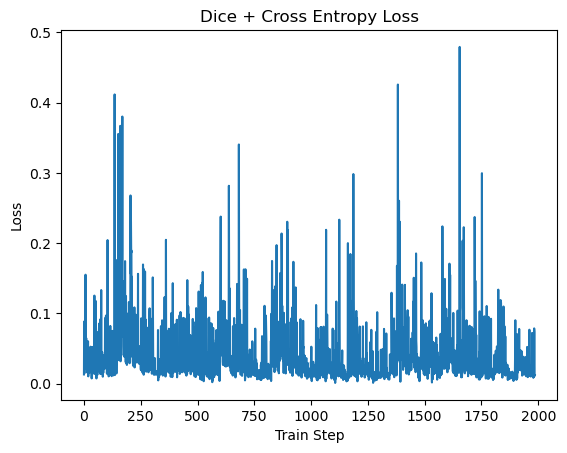

In [23]:
plt.plot(losses)
plt.title("Dice + Cross Entropy Loss")
plt.xlabel("Train Step")
plt.ylabel("Loss")
plt.show("./figs/unet_losses.png")

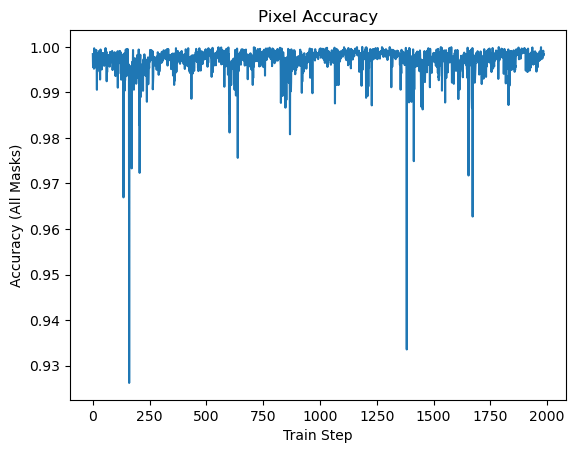

In [24]:
plt.plot(accs)
plt.title("Pixel Accuracy")
plt.xlabel("Train Step")
plt.ylabel("Accuracy (All Masks)")
plt.show("./figs/unet_losses.png")

In [34]:
results = pd.DataFrame(columns = ["Patient", "Brightness", "Accuracy"])
model.eval()
losses = []
test_ious = []
test_class_ious = [[] for _ in range(7)]
seg_loss = DiceLoss(softmax=True, squared_pred=True, reduction="mean") #TODO: try adding weights
ce_loss = nn.CrossEntropyLoss()

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

with torch.no_grad():
    for img, seg, patient, b_level in test_loader:
        img = img.to(device)
        seg = seg.to(device)

        img = img.unsqueeze(dim=1)

        outputs = model(img)
        target_1hot = F.one_hot(seg, num_classes=outputs.shape[1]).permute(0, 3, 1, 2).float()
        pred = torch.argmax(outputs, dim=1)

        loss = seg_loss(outputs, target_1hot) + ce_loss(outputs, seg)
        losses.append(loss.item())
        accuracy = (torch.tensor(pred).clone().detach() == seg).float().mean(dim=(1, 2))
        acc = accuracy.clone().cpu().numpy()
        
        # Calculate IoU using existing function
        mean_iou, class_iou = calculate_iou(outputs, seg)
        test_ious.append(mean_iou)
        
        # Store class IoUs
        for i, iou in enumerate(class_iou):
            test_class_ious[i].append(iou)

        results = pd.concat([results, pd.DataFrame({"Patient": patient, "Brightness": b_level, "Accuracy": acc})]) #TODO: add ious



/tmp/ipykernel_418322/1078130104.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({"Patient": patient, "Brightness": b_level, "Accuracy": acc})]) #TODO: add ious


In [36]:
grouped_unet_results = results.groupby(["Patient", "Brightness"]).mean()

In [37]:
grouped_unet_results

Accuracy
Patient           Brightness                      
ACRIN 6698_277831 NEW Brightness level 6  0.998301
                  NEW Brightness level 7  0.998287

### DINO

In [4]:
import torch
import torch.nn as nn
from transformers import AutoModel, ViTImageProcessor

from monai.losses import DiceLoss
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

from src.utils import calculate_iou

In [5]:
# Define the DINOv2 model with linear probe
class DINOv2LinearProbe(nn.Module):
    def __init__(self, num_classes): 
        super(DINOv2LinearProbe, self).__init__()
        # Load DINOv2 model
        self.backbone = AutoModel.from_pretrained("facebook/dinov2-small")
        self.feature_extractor = ViTImageProcessor.from_pretrained("facebook/dinov2-small")
        
        # Freeze the backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # Get the feature dimension from the backbone
        self.feature_dim = self.backbone.config.hidden_size
        
        # Linear probe
        self.linear_probe = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        # Extract features from the backbone
        features = self.backbone(x).last_hidden_state[:, 0]  # Use [CLS] token
        # Apply linear probe
        logits = self.linear_probe(features)
        return logits

# Define the segmentation model with DINOv2 backbone
class DINOv2Segmentation(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Initialize DINOv2 backbone
        self.backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
        self.feature_dim = 384  # DINOv2-small feature dimension
        
        # Freeze backbone parameters
        for param in self.backbone.parameters():
            param.requires_grad = False
            
        # Decoder network with skip connections
        self.decoder = nn.Sequential(
            # First block
            nn.Conv2d(self.feature_dim, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            # Second block
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            # Third block
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # Final 1x1 conv for classification
            nn.Conv2d(64, 7, kernel_size=1)
        )
        
    def forward(self, x):
        # Get features from DINOv2 backbone
        features_dict = self.backbone.forward_features(x)
        
        # Extract patch tokens from the dictionary
        features = features_dict['x_norm_patchtokens']  # Shape: [B, N, D]
        B = x.shape[0]
        
        # Reshape features from [B, N, D] to [B, D, H, W]
        # N = H * W = 16 * 16 = 256 for 224x224 input
        features = features.permute(0, 2, 1)  # [B, D, N]
        features = features.reshape(B, -1, 16, 16)  # [B, D, H, W]
        
        # Apply decoder
        x = self.decoder(features)
        
        # Upsample to input size
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        
        return x

In [6]:
print("Creating model...")
model = DINOv2Segmentation()
model = model.to(device)

#TODO: add this to all models
class_weights =  torch.tensor([ 1.3570,  1.6794,  7.6094,  3.8674,  7.3526, 51.9940, 99.0545])
class_weights = class_weights/class_weights.sum()
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Loss function with class weights to combat class imbalance
ce_loss = nn.CrossEntropyLoss(weight=class_weights)
seg_loss = DiceLoss(
    to_onehot_y=True, 
    softmax=True,
    include_background=True,
    batch=True,
    weight=class_weights
)
# seg_loss = DiceLoss(softmax=True, squared_pred=True, reduction="mean") #TODO: check other params for importance

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Creating model...


Using cache found in /home/ra-ugrad/.cache/torch/hub/facebookresearch_dinov2_main
/home/ra-ugrad/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/ra-ugrad/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/ra-ugrad/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
/tmp/ipykernel_526261/217109297.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)


In [7]:
# Training loop
print("Starting training...")
losses = []
accs = []

for epoch in range(1):
    model.train()
    train_loss = 0
    batch_count = 0
    
    for step, (img, seg, patient, b_level) in enumerate(tqdm(test_loader)):
        img = img.to(device)
        seg = seg.to(device)

        B, H, W = img.size()
        img_3c = img.repeat(3, 1, 1, 1).view(B, 3, H, W)
        mask = seg.unsqueeze(dim=1)

        # Forward pass
        outputs = model(img_3c)
        
        # Reshape outputs and masks for loss calculation
        outputs = outputs.view(-1, 7, 224, 224)
        pred = torch.argmax(outputs, dim=1)
        
        loss = seg_loss(outputs, mask) + ce_loss(outputs, seg)
        acc = (pred == seg).float().mean()
        accs.append(acc.item())
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())

Starting training...


100%|██████████| 984/984 [00:47<00:00, 20.91it/s]


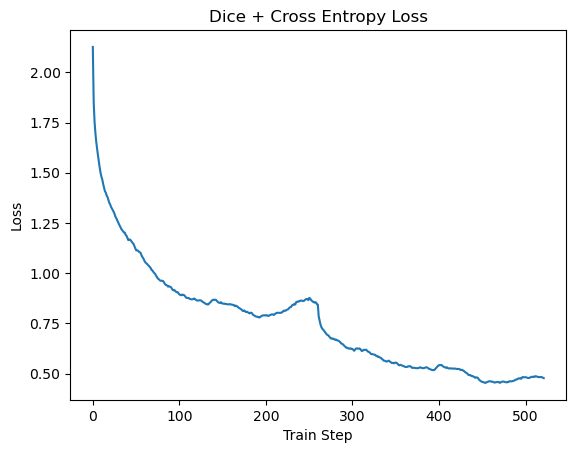

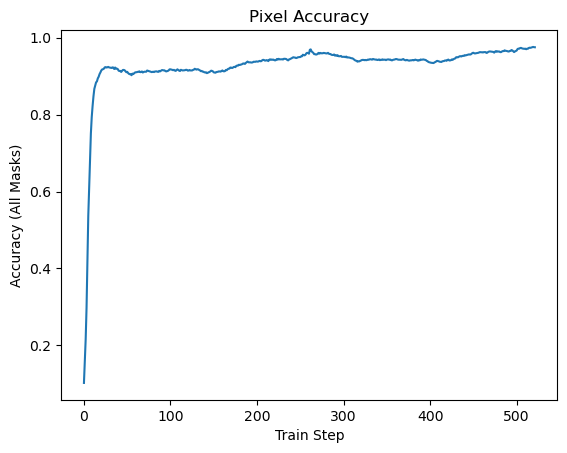

In [9]:
plt.plot(losses)
plt.title("Dice + Cross Entropy Loss")
plt.xlabel("Train Step")
plt.ylabel("Loss")
plt.show()

plt.plot(accs)
plt.title("Pixel Accuracy")
plt.xlabel("Train Step")
plt.ylabel("Accuracy (All Masks)")
plt.show()

In [ ]:
results = pd.DataFrame(columns = ["Patient", "Brightness", "Accuracy"])

model.eval()
losses = []
test_ious = []
test_class_ious = [[] for _ in range(7)]
ce_loss = nn.CrossEntropyLoss(weight=class_weights)
seg_loss = DiceLoss(
    to_onehot_y=True, 
    softmax=True,
    include_background=True,
    batch=True,
    weight=class_weights
)

with torch.no_grad():
    for img, seg, patient, b_level in test_loader:
        img = img.to(device)
        seg = seg.to(device)

        B, H, W = img.size()
        img_3c = img.repeat(3, 1, 1, 1).view(B, 3, H, W)
        mask = seg.unsqueeze(dim=1)
        
        outputs = model(img_3c)
        outputs = outputs.view(-1, 7, 224, 224)
        pred = torch.argmax(outputs, dim=1)
        
        loss = seg_loss(outputs, mask) + ce_loss(outputs, seg)
        losses.append(loss.item())
        acc = list((pred == seg).float().mean(dim =(1, 2)).cpu().numpy())
        # Calculate IoU using existing function
        mean_iou, class_iou = calculate_iou(outputs, seg, 7)
        
        # Store class IoUs
        
        for i, iou in enumerate(class_iou):
            test_class_ious[i].append(iou)

        results = pd.concat([results, pd.DataFrame({"Patient": patient, 
                                                    "Brightness": b_level, 
                                                    "Accuracy": acc,
                                                    "IoU_0": class_iou[0],
                                                    "IoU_1": class_iou[1],
                                                    "IoU_2": class_iou[2],
                                                    "IoU_3": class_iou[3], 
                                                    "IoU_4": class_iou[4],
                                                    "IoU_5": class_iou[5],
                                                    "IoU_6": class_iou[6],
                                                    "IoU_mean": mean_iou,
                                                    })]) 

/tmp/ipykernel_526261/1273860678.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({"Patient": patient,


In [21]:
first_values = [sublist[1] for sublist in class_iou]
sum(first_values) / len(class_iou)

0.28548513861844627

In [67]:
# Convert predictions to class indices
pred = torch.argmax(outputs, dim=1)

In [55]:
len(test_class_ious)

7

In [9]:
grouped_dino_results = results.groupby(["Patient", "Brightness"]).mean()

In [10]:
grouped_dino_results

Accuracy     IoU_0     IoU_1     IoU_2  \
Patient  Brightness                                                       
Duke_062 NEW Brightness level 1  0.952116  0.990830  0.949926  0.044642   
         NEW Brightness level 2  0.952120  0.990809  0.950064  0.043185   
         NEW Brightness level 3  0.952140  0.990777  0.950120  0.044775   
         NEW Brightness level 4  0.952034  0.990767  0.950130  0.044118   

                                    IoU_3     IoU_4  IoU_5  IoU_6  IoU_mean  
Patient  Brightness                                                          
Duke_062 NEW Brightness level 1  0.249779  0.176722    0.0    0.0  0.344394  
         NEW Brightness level 2  0.247999  0.177553    0.0    0.0  0.344394  
         NEW Brightness level 3  0.250484  0.176210    0.0    0.0  0.344502  
         NEW Brightness level 4  0.251303  0.174347    0.0    0.0  0.344502

### nn-Unet

### Swin UNETR